In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [2]:
d, Nobs = 2000, 3000
X = sprandn(d, Nobs, 5e-2)
X[1,:] = ones(Nobs)
ξ_true = 3*sprandn(d, 1e-2)
ξ_true[1] = 3*randn()
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

#### Define prior:

In [3]:
σ02 = 1
prior = SS_prior(d, σ02);

#### Define model:

In [4]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

#### Define minibatch sampler:

In [5]:
mb_size = 100
weights_het = spzeros(d, Nobs)
@showprogress for i in 1:d 
    nzind = X[i,:].nzind
    weights_het[i,nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
end

prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
@showprogress for i in 2:d 
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


#### Define output scheduler:

In [16]:
A_xi = ones(1,d)/d
A_hyp = ones(1,hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(5*10^7, 10^7)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [17]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e3)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [18]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10% attempts in 65.8 mins 
20% attempts in 127.5 mins 
Trimmed after 10000000 bouncing attempts 
30% attempts in 189.47 mins 
40% attempts in 250.9 mins 
50% attempts in 312.18 mins 
60% attempts in 372.54 mins 
70% attempts in 432.76 mins 
80% attempts in 492.99 mins 
90% attempts in 552.81 mins 
100% attempts in 612.79 mins 


In [19]:
print(maximum(abs.(outp.opf.xi_mu - mstate.mu)), "\n")
print(maximum(abs.(outp.opf.xi_m2 - mstate.m2)))

0.39775989284618873
8.879523890051559

* Number of bounces:

In [20]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tot_bounces-sum(mstate.n_bounces)
@printf("ZZ total bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ total bounces: 1543717, hyper bounces: 192127

In [22]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.02721416

In [23]:
post_mean_gzz = outp.opf.xi_mu
# post_median_gzz = median(xi_samples,2);

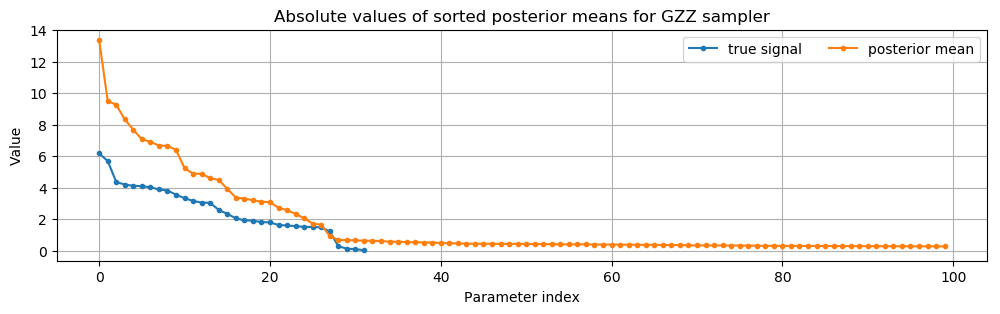

In [28]:
fig = figure(figsize=(12,3))
plot(sort(abs.(ξ_true.nzval), rev=true), "o-", markersize=3, label="true signal")
plot(sort(vec(abs.(post_mean_gzz)), rev=true)[1:100], "o-", markersize=3, label="posterior mean")
# plot(sort(vec(abs.(post_median_gzz)), rev=true)[1:50], "o-", markersize=3, label="posterior median")
grid(true)
title("Absolute values of sorted posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value")
savefig("plots/postmeansdcomplete2K.pdf", format="pdf", dpi=10000, bbox_inches="tight")

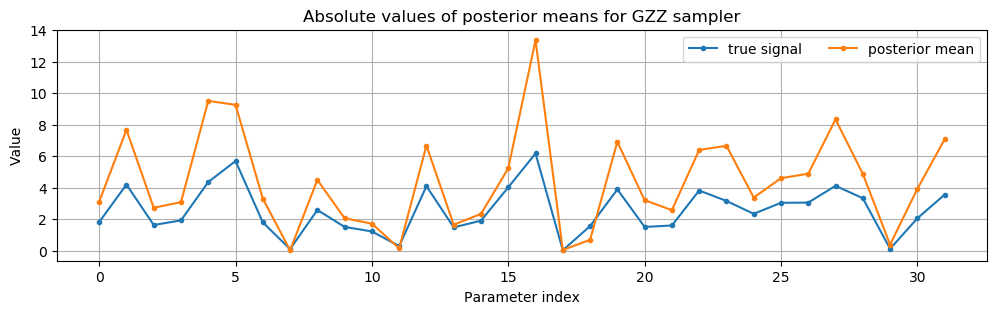

In [27]:
fig = figure(figsize=(12,3))
plot(abs.(ξ_true.nzval), "o-", markersize=3, label="true signal")
plot(vec(abs.(post_mean_gzz))[ξ_true.nzind], "o-", markersize=3, label="posterior mean")
grid(true)
title("Absolute values of posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value")
savefig("plots/postmeansd2K.pdf", format="pdf", dpi=10000, bbox_inches="tight")